In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('df.csv')

print(df.head())

   ReceiverID    ActionType  NegoOutcome  \
0          32         Offer  FinalAccept   
1          31  Counteroffer  FinalAccept   
2          32  Counteroffer  FinalAccept   
3          31  Counteroffer  FinalAccept   
4          32      Question  FinalAccept   

                                             Content  Length  \
0  hey chris great working together competition h...    1778   
1  hey alex pleasure mine starters think importan...    1949   
2  hey chris thank response glad hear agree date ...     693   
3  hello alex think solid compromis settled willi...     452   
4  dear chris glad hear willing accept terms come...    1349   

   Word count of nego message  NegoOutcomeLabel  \
0                         309                 1   
1                         337                 1   
2                         123                 1   
3                          77                 1   
4                         249                 1   

                                    Filtere

In [2]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import pickle
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize the text data
def tokenize_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    return inputs

# Apply tokenization to the 'Content' column
df['Tokenized_Content'] = df['Content'].apply(tokenize_text)

# Perform inference using the model
def get_embeddings(tokenized_text):
    with torch.no_grad():
        outputs = model(**tokenized_text)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply the model to get embeddings for each tokenized text
df['Embeddings'] = df['Tokenized_Content'].apply(get_embeddings)


# Save the DataFrame to a pickle file
with open('df_with_embeddings.pkl', 'wb') as f:
    pickle.dump(df, f)

# Optionally, save the DataFrame to a CSV file (without embeddings)
df.drop(columns=['Tokenized_Content', 'Embeddings']).to_csv('df_with_embeddings.csv', index=False)

# Display the DataFrame with embeddings
print(df.head())

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   ReceiverID    ActionType  NegoOutcome  \
0          32         Offer  FinalAccept   
1          31  Counteroffer  FinalAccept   
2          32  Counteroffer  FinalAccept   
3          31  Counteroffer  FinalAccept   
4          32      Question  FinalAccept   

                                             Content  Length  \
0  hey chris great working together competition h...    1778   
1  hey alex pleasure mine starters think importan...    1949   
2  hey chris thank response glad hear agree date ...     693   
3  hello alex think solid compromis settled willi...     452   
4  dear chris glad hear willing accept terms come...    1349   

   Word count of nego message  NegoOutcomeLabel  \
0                         309                 1   
1                         337                 1   
2                         123                 1   
3                          77                 1   
4                         249                 1   

                                    Filtere

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


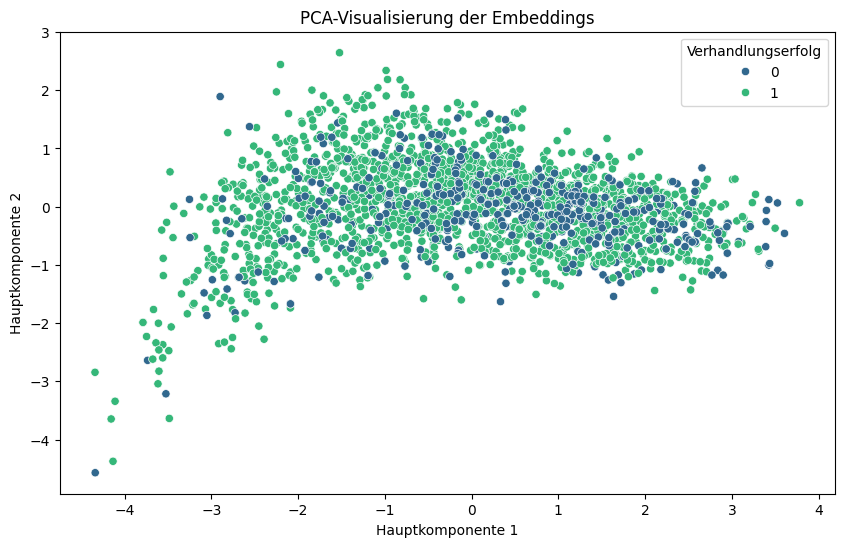

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the embeddings
df = pickle.load(open('df_with_embeddings.pkl', 'rb'))

# Extract the embeddings and labels
X = df['Embeddings'].tolist()
y = df['NegoOutcomeLabel']

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", legend="full")
plt.title("PCA Visualization of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Negotiation Outcome")
plt.show()


There is high overlap between the two classes so it can be said that there is no distinct clustering, meaning there is no immediate seeable connection between content of the message and the negotiation outcomeand 




**Now we try to measure for overfitting and try to make prediction with the random forest classifier**

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.7849223946784922

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.10      0.17       104
           1       0.79      0.99      0.88       347

    accuracy                           0.78       451
   macro avg       0.78      0.54      0.52       451
weighted avg       0.78      0.78      0.71       451



In [32]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the DataFrame with embeddings from the pickle file
with open('df_with_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)

# Define target variable (label) and features
X = df['Embeddings'].tolist()  # BERT embeddings as features
y = df['NegoOutcomeLabel']     # Target variable for success (1) or no success (0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classification model (e.g., Random Forest)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Test the model
y_pred = clf.predict(X_test)

# Evaluate the results
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Model Accuracy: 0.7849223946784922

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.10      0.17       104
           1       0.79      0.99      0.88       347

    accuracy                           0.78       451
   macro avg       0.78      0.54      0.52       451
weighted avg       0.78      0.78      0.71       451



In [33]:
# Model accuracy on training data
train_accuracy = clf.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

# Model accuracy on test data
test_accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Train Accuracy: 1.00
Test Accuracy: 0.78


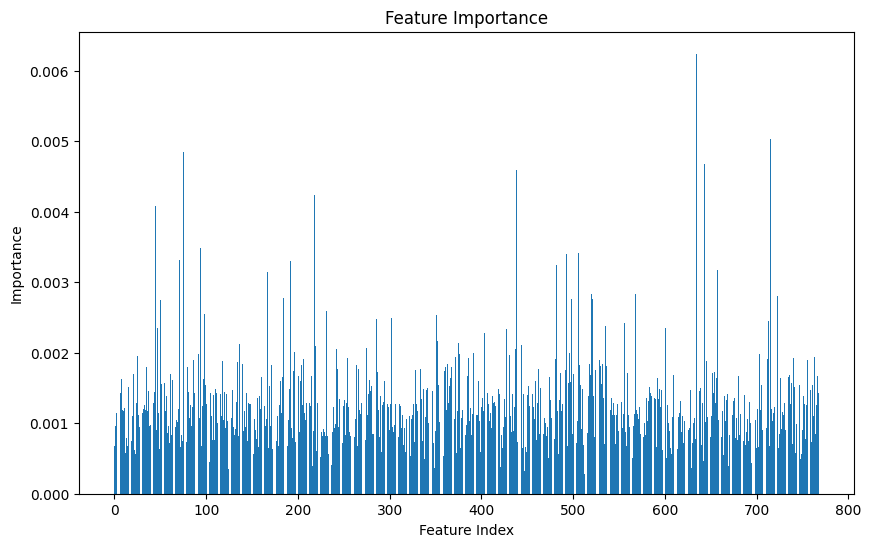

In [ ]:
# Feature-Wichtigkeit extrahieren
importances = clf.feature_importances_

# Sortieren und visualisieren
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import learning_curve
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load the DataFrame with embeddings from the pickle file
with open('df_with_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)

# Extract target variable and features
X = np.array(df['Embeddings'].tolist())  # BERT embeddings as features
y = df['NegoOutcomeLabel']              # Target variable

# Function: Apply Random Oversampling
def apply_random_oversampling(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print(f"New class distribution: {np.bincount(y_resampled)}")
    return X_resampled, y_resampled

# Apply Random Oversampling
X_resampled, y_resampled = apply_random_oversampling(X, y)

# Optional: Train a classification model with the resampled data
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate results
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Neue Klassenverteilung: [1795 1795]
Model Accuracy: 0.9777158774373259

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.97      0.99      0.98       363

    accuracy                           0.98       718
   macro avg       0.98      0.98      0.98       718
weighted avg       0.98      0.98      0.98       718



In [ ]:

train_accuracy = clf.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")


test_accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.98


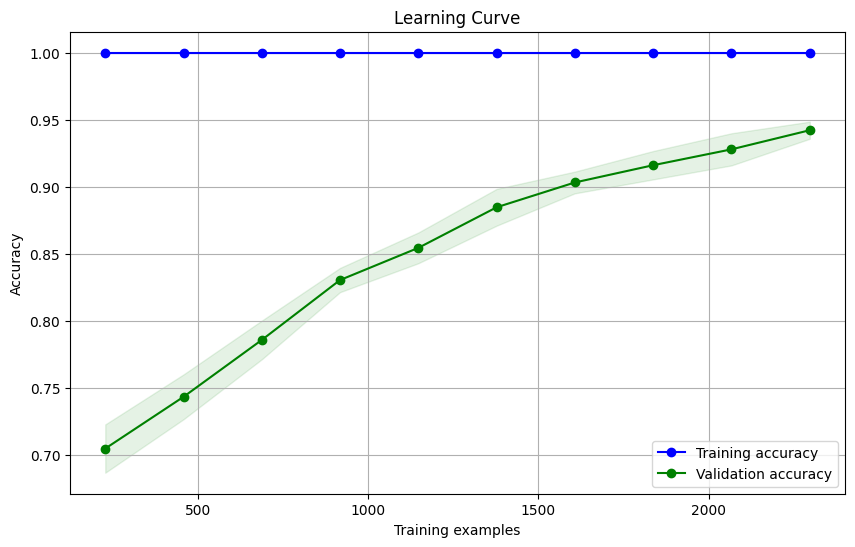

In [ ]:
# Lernkurven erstellen
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Mittelwert und Standardabweichung der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lernkurven plotten
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
# Cross-Validation mit 5 Folds
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

# Ergebnisse der Cross-Validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.2f}")

# Optional: Trainiere das Modell auf dem gesamten Trainingsdatensatz
clf.fit(X, y)

Cross-Validation Scores: [0.80044346 0.85365854 0.77827051 0.7827051  0.82222222]
Mean CV Accuracy: 0.81
Standard Deviation of CV Accuracy: 0.03


RandomForestClassifier(random_state=42)

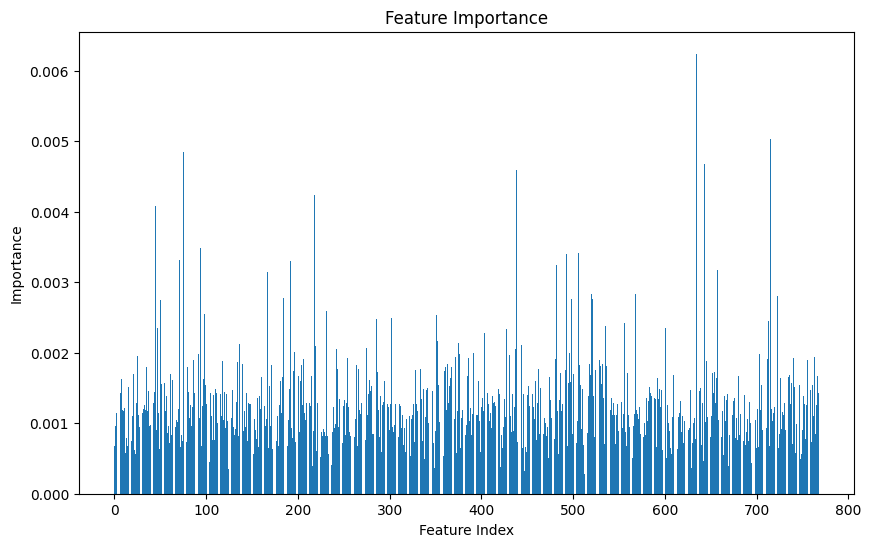

In [ ]:
# Feature-Wichtigkeit extrahieren
importances = clf.feature_importances_

# Sortieren und visualisieren
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

**Conclusion**


Although the validation accuracy has been significantly improved, the model still suffers from severe overfitting, as indicated by the perfect training accuracy and considerably lower test accuracy. This highlights that the model fails to generalize well to unseen data and is overly reliant on patterns specific to the training set.

Additionally, the PCA visualization of embeddings has already demonstrated that there is no clear or recognizable relationship between the content of the messages and the negotiation outcomes. This suggests that the embeddings, as they currently represent the data, do not capture the key factors influencing negotiation success. Further exploration or alternative data sources may be required to achieve meaningful predictions.